In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

def completar_datos_regresion_multiple(data_xts):
    # Guardar una copia de la serie original
    serie_original = data_xts.copy()

    # Asegurarse de que los datos sean numéricos y excluir la columna de fechas
    if 'Fecha' in data_xts.columns:
        data_xts = data_xts.set_index('Fecha')
    data_xts = data_xts.astype(float)

    # Variables de seguimiento
    prev_na_count = float('inf')
    estaciones_excluidas = []
    iteration = 0
    errores_rmse = {}  # Para guardar el RMSE de cada estación

    while True:
        iteration += 1
        
        # Identificar valores faltantes
        nas_por_estacion = data_xts.isna().sum()
        porcentaje_nas = nas_por_estacion / len(data_xts) * 100
        
        # Filtrar estaciones válidas
        estaciones_validas = porcentaje_nas[porcentaje_nas <= 30].index.tolist()
        estaciones_invalidas = porcentaje_nas[porcentaje_nas > 30].index.tolist()
        
        # Registrar estaciones excluidas
        estaciones_excluidas.extend(estaciones_invalidas)
        
        if not estaciones_validas:
            print("No quedan estaciones con menos del 30% de datos faltantes.")
            break

        # Ordenar estaciones por número de valores faltantes
        estaciones_ordenadas = nas_por_estacion[estaciones_validas].sort_values(ascending=False).index.tolist()
        
        # Verificar mejora
        total_nas = nas_por_estacion.sum()
        if total_nas == 0 or total_nas >= prev_na_count:
            print("No hay más mejoras o todos los NAs han sido completados.")
            break

        prev_na_count = total_nas

        # Completar datos faltantes por estación
        for columna_a_completar in estaciones_ordenadas:
            if nas_por_estacion[columna_a_completar] > 0:
                # Seleccionar predictores
                predictores = [col for col in estaciones_validas if col != columna_a_completar]
                if not predictores:
                    continue
                
                # Crear conjuntos de entrenamiento
                data_entrenamiento = data_xts.dropna(subset=[columna_a_completar])
                if data_entrenamiento.empty:
                    continue

                X = data_entrenamiento[predictores]
                y = data_entrenamiento[columna_a_completar]
                
                # Eliminar valores problemáticos
                mask = ~X.isna().any(axis=1)
                X = X[mask]
                y = y[mask]

                if X.empty or y.empty:
                    continue
                
                # Dividir los datos en entrenamiento (80%) y prueba (20%)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                # Modelo de regresión múltiple
                modelo_multiple = LinearRegression()
                try:
                    modelo_multiple.fit(X_train, y_train)
                    
                    # Calcular predicciones en el conjunto de prueba y el RMSE
                    y_pred = modelo_multiple.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    errores_rmse[columna_a_completar] = rmse
                except ValueError as e:
                    print(f"Error al ajustar modelo para {columna_a_completar}: {e}")
                    continue
                
                # Predecir valores faltantes
                data_faltantes = data_xts[data_xts[columna_a_completar].isna()]
                if not data_faltantes.empty:
                    X_faltantes = data_faltantes[predictores]
                    X_faltantes = X_faltantes.dropna(axis=0, how='any')  # Asegurarse de no predecir con NaN
                    if not X_faltantes.empty:
                        predicciones = modelo_multiple.predict(X_faltantes)
                        data_xts.loc[X_faltantes.index, columna_a_completar] = predicciones

        print(f"Iteración {iteration} - Total NAs restantes: {total_nas}")
        if iteration > 5:
            break

    # Retornar datos completados, serie original, estaciones excluidas y errores RMSE
    return {
        "SerieOriginal": serie_original,
        "SerieCompletada": data_xts,
        "EstacionesExcluidas": list(set(estaciones_excluidas)),
        "ErroresRMSE": errores_rmse
    }

# Cargar los datos y ejecutar la función
gauges = pd.read_csv('datos_meses.csv')
resultado = completar_datos_regresion_multiple(data_xts=gauges)

# Imprimir resultados
print("Estaciones Excluidas:", resultado["EstacionesExcluidas"])
print("Errores RMSE por estación:", resultado["ErroresRMSE"])
print("Serie Original:")
print(resultado["SerieOriginal"].head())
print("Serie Completada:")
print(resultado["SerieCompletada"].head())

Iteración 1 - Total NAs restantes: 380
Iteración 2 - Total NAs restantes: 248
No hay más mejoras o todos los NAs han sido completados.
Estaciones Excluidas: ['chusis']
Errores RMSE por estación: {'chalaco': 27.649135804555325, 'miraflores': 71.04806957788057, 'huancabamba': 19.474299643618888, 'huamarca': 31.190110579614824}
Serie Original:
        Fecha  chusis  chalaco  huamarca  huancabamba  miraflores
0  1980-01-31     0.0     70.4      38.7         23.5         0.2
1  1980-02-29     0.0    108.7     139.0         35.9         2.5
2  1980-03-31     6.4    121.6     116.9         51.3        13.7
3  1980-04-30     7.6    178.0     129.1          NaN        35.2
4  1980-05-31     0.0     42.5      17.9         22.1         0.3
Serie Completada:
            chusis  chalaco  huamarca  huancabamba  miraflores
Fecha                                                         
1980-01-31     0.0     70.4      38.7    23.500000         0.2
1980-02-29     0.0    108.7     139.0    35.900000    

In [48]:
def graficar_rmse_por_estacion(errores_rmse):
    """
    Grafica en barras los RMSE por cada estación.

    Args:
    - errores_rmse (dict): Diccionario con los nombres de las estaciones como claves y sus RMSE como valores.
    """
    # Verificar que haya datos para graficar
    if not errores_rmse:
        print("No hay valores de RMSE para graficar.")
        return

    # Crear el gráfico de barras
    estaciones = list(errores_rmse.keys())
    valores_rmse = list(errores_rmse.values())

    plt.figure(figsize=(10, 6))
    plt.bar(estaciones, valores_rmse, color='skyblue', edgecolor='black', alpha=0.8)
    plt.title("RMSE por Estación", fontsize=16)
    plt.xlabel("Estaciones", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()


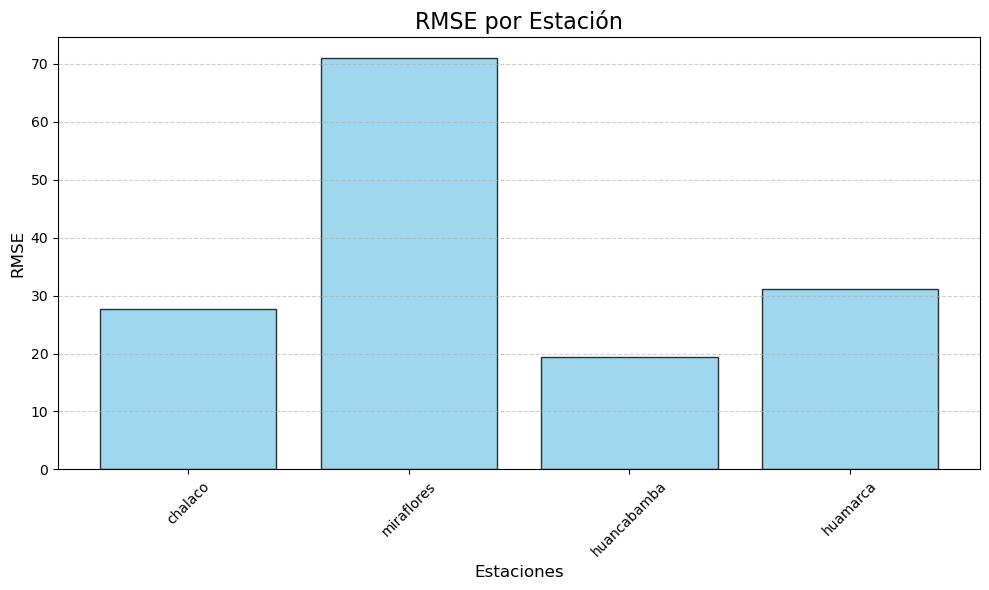

In [49]:
# Obtener los RMSE del resultado
errores_rmse = resultado["ErroresRMSE"]

# Graficar los RMSE por estación
graficar_rmse_por_estacion(errores_rmse)

In [45]:
import matplotlib.pyplot as plt

def graficar_comparacion(resultado, estacion):
    """
    Grafica y compara las series originales y completadas para una estación específica.
    
    Args:
    - resultado (dict): Resultado de la función `completar_datos_regresion_multiple`, 
                        debe contener 'SerieOriginal' y 'SerieCompletada'.
    - estacion (str): Nombre de la estación a graficar.
    """
    # Verificar que la estación exista en los datos
    if estacion not in resultado["SerieOriginal"].columns:
        print(f"La estación '{estacion}' no existe en los datos.")
        return

    # Extraer las series original y completada
    serie_original = resultado['SerieOriginal'][estacion]
    serie_completada = resultado['SerieCompletada'][estacion]

    # Crear la gráfica
    plt.figure(figsize=(12, 6))
    plt.plot(serie_original, label="Serie Original", color="blue", alpha=0.7)
    plt.plot(serie_completada, label="Serie Completada", color="orange", linestyle="--", alpha=0.7)
    
    # Añadir detalles
    plt.title(f"Comparación de la Estación: {estacion}", fontsize=16)
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Precipitación", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    
    # Mostrar la gráfica
    plt.show()


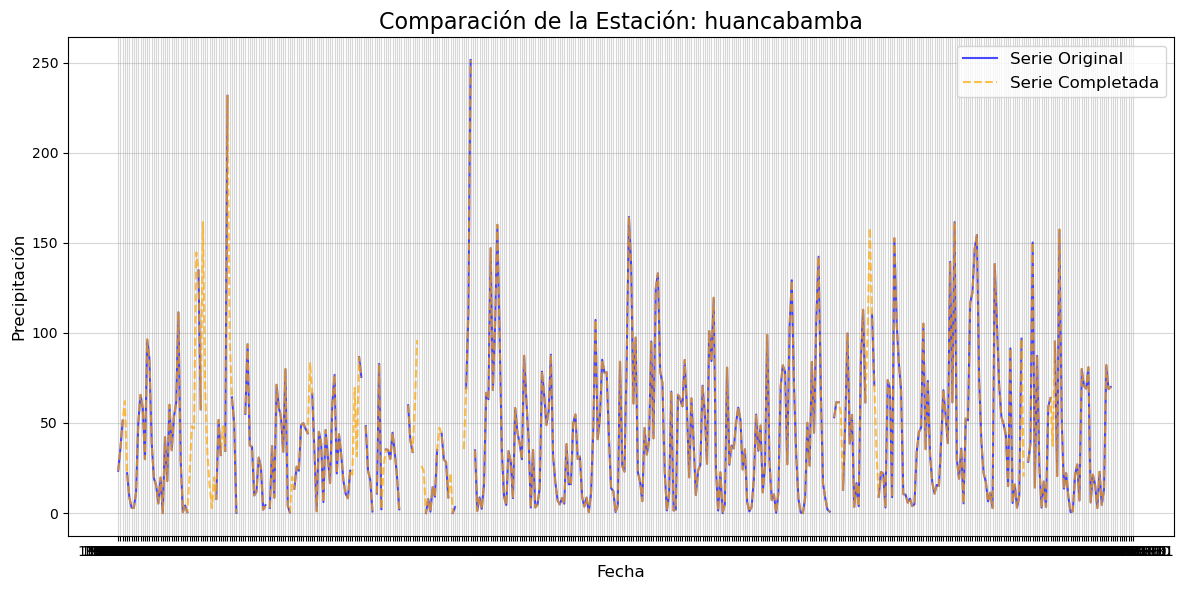

In [41]:
# Graficar la comparación para la estación 'chusis'
graficar_comparacion(resultado, 'huancabamba')

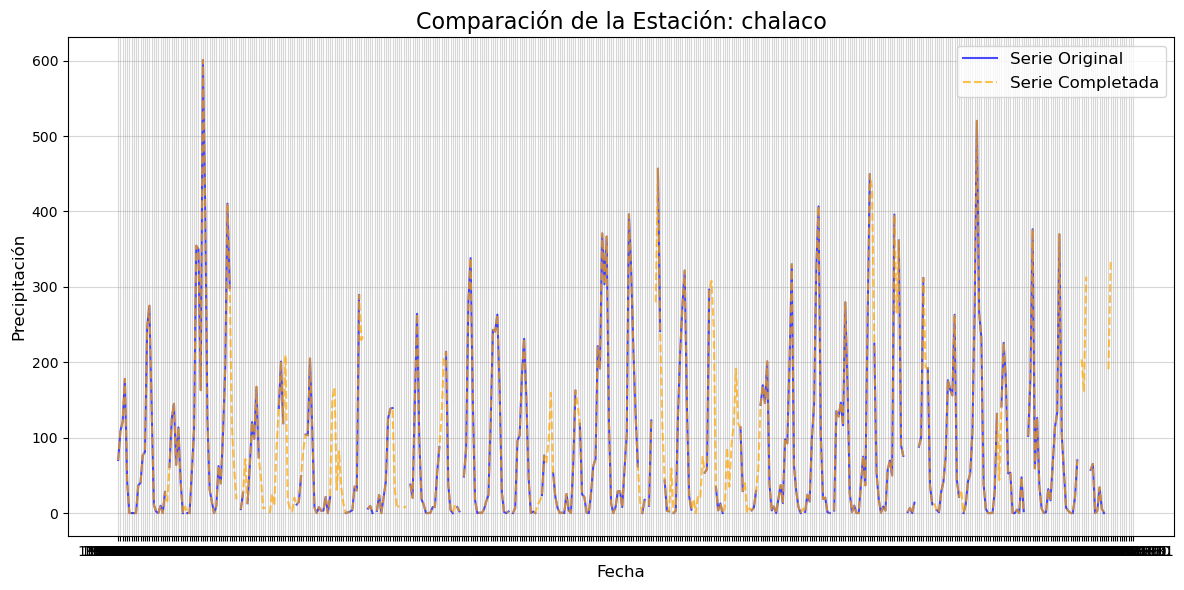

In [34]:
# Graficar la comparación para la estación 'chusis'
graficar_comparacion(resultado, 'chalaco')

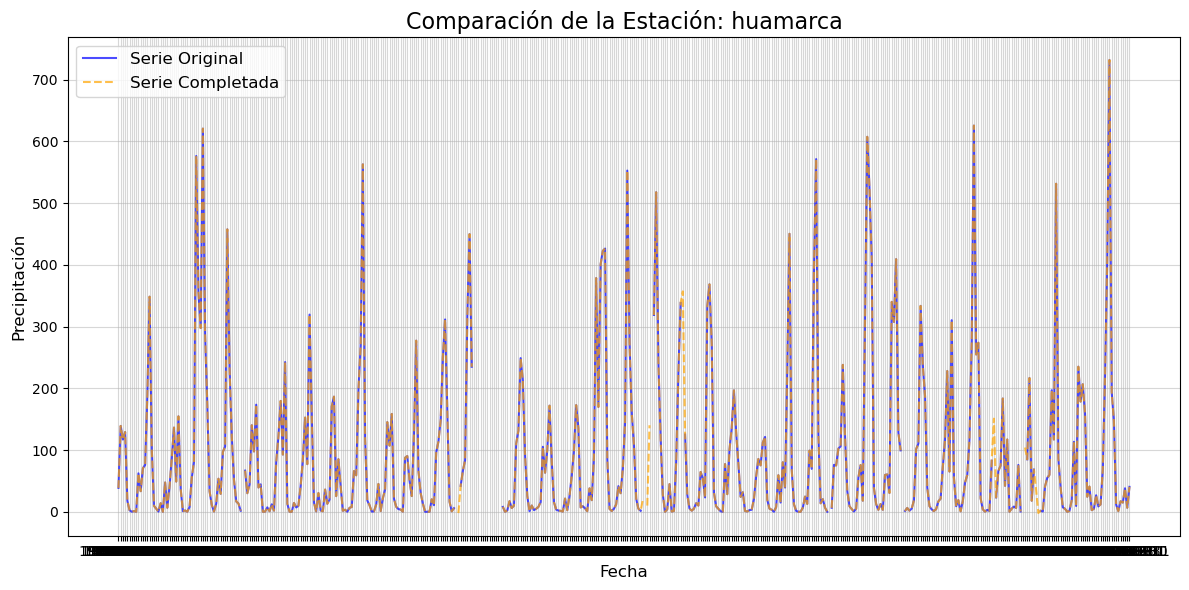

In [38]:
# Graficar la comparación para la estación 'chusis'
graficar_comparacion(resultado, 'huamarca')

In [46]:
def calcular_matriz_correlacion(data):
    """
    Calcula la matriz de correlación entre las estaciones.

    Args:
    - data (DataFrame): DataFrame con los datos de las estaciones.

    Returns:
    - matriz_correlacion (DataFrame): Matriz de correlación entre las estaciones.
    """
    # Calcular la matriz de correlación
    matriz_correlacion = data.corr()
    return matriz_correlacion


def graficar_matriz_correlacion(matriz_correlacion):
    """
    Grafica la matriz de correlación utilizando un mapa de calor.

    Args:
    - matriz_correlacion (DataFrame): Matriz de correlación entre las estaciones.
    """
    # Crear el mapa de calor
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Matriz de Correlación entre Estaciones", fontsize=16)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

               chusis   chalaco  huamarca  huancabamba  miraflores
chusis       1.000000  0.271931  0.378110     0.128174    0.870017
chalaco      0.271931  1.000000  0.943225     0.767466    0.443717
huamarca     0.378110  0.943225  1.000000     0.765709    0.465570
huancabamba  0.128174  0.767466  0.765709     1.000000    0.220721
miraflores   0.870017  0.443717  0.465570     0.220721    1.000000


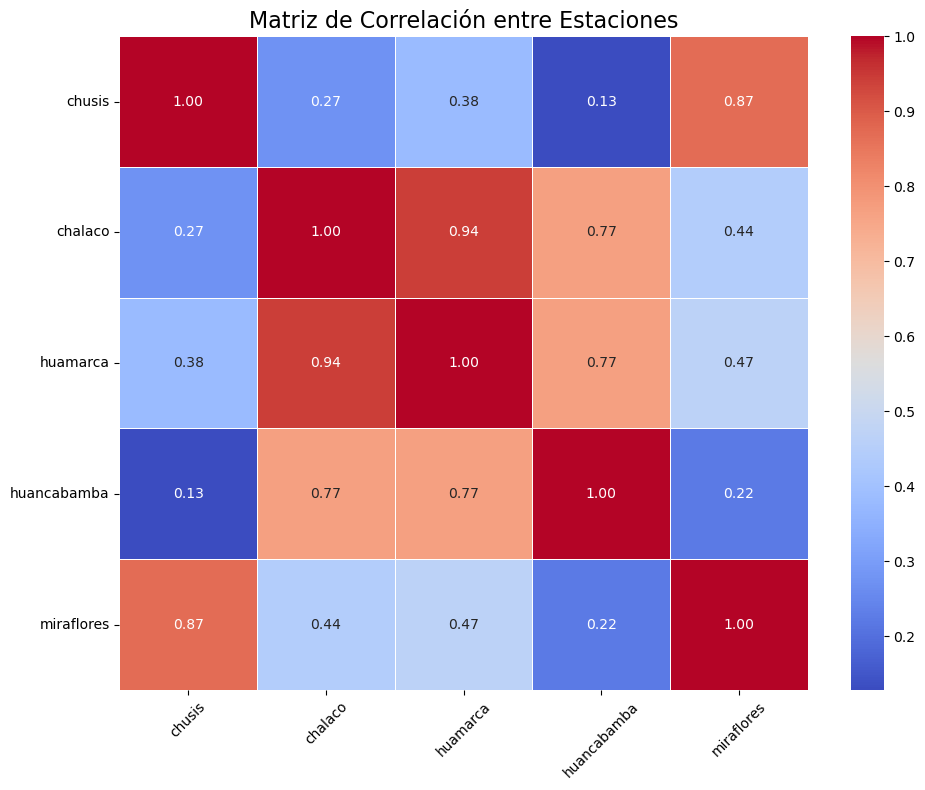

In [47]:
matriz_correlacion = calcular_matriz_correlacion(resultado["SerieCompletada"])

# Mostrar la matriz de correlación
print(matriz_correlacion)

# Graficar la matriz de correlación
graficar_matriz_correlacion(matriz_correlacion)

In [50]:
gauges.describe()

,chusis,chalaco,huamarca,huancabamba,miraflores
count,305.000000,365.000000,427.000000,405.000000,398.000000
mean,7.800984,85.395342,91.103981,42.845432,18.686181
std,49.493206,109.523783,128.455958,39.411589,78.976276
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000,6.500000,10.600000,0.000000
50%,0.000000,37.500000,38.700000,34.000000,0.300000
75%,1.200000,126.200000,117.300000,63.200000,3.375000
max,612.600000,600.900000,731.600000,251.500000,768.700000
